In [90]:
#NOTE: we assume all time series data in PST time. Only time we are working with non PST data is when 
# we receive data and then convert. See get_occupancy function for how to do that.
# base imports
import time
from collections import defaultdict
%matplotlib inline
import pandas as pd
from copy import copy
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pytz
tz = pytz.timezone("US/Pacific")
import doctest
import matplotlib.lines as plt_line
import matplotlib

In [7]:
# for fetching data
from xbos import get_client
from xbos.services.pundat import DataClient, timestamp, make_dataframe, merge_dfs
from xbos.services.hod import HodClient

In [8]:
# get a bosswave client
c = get_client(entity="/Users/Daniel/CIEE/SetUp/ciee_readonly.ent", agent="127.0.0.1:28589")
# get a HodDB client
hod = HodClient("ciee/hod", c)
# get an archiver client
archiver = DataClient(c,archivers=["ucberkeley"])

Saw [ciee/hod] HodDB 812.519 ms ago
Saw [ucberkeley] archiver 6 seconds 663.421 ms ago


In [40]:
# define a Brick query to get the temperature information
q = """SELECT ?x ?hvaczone ?uuid WHERE { 
?x bf:controls/bf:feeds ?hvaczone .
 ?hvaczone rdf:type brick:HVAC_Zone .
?x rdf:type/rdfs:subClassOf* brick:Thermostat .
  ?x bf:hasPoint ?status .
  ?status rdf:type brick:Thermostat_Status .
  ?status bf:uuid ?uuid .
};
"""
res = hod.do_query(q)['Rows']
zones = defaultdict(lambda: defaultdict(list))
for sensor in res:
    zones[sensor["?hvaczone"]]["Heating"].append(sensor["?uuid"])


In [47]:
# define a Brick query to get the occupancy information
q = """SELECT ?zone ?sensor_uuid WHERE {
   ?zone rdf:type brick:HVAC_Zone .
   ?zone bf:hasPart ?room .
   ?sensor bf:isLocatedIn ?room .
   ?sensor rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
   ?sensor bf:uuid ?sensor_uuid .
};
"""
res = hod.do_query(q)['Rows']
for sensor in res:
    zones[sensor['?zone']]["Occupancy"].append(sensor['?sensor_uuid'])

In [60]:
test_zones = {"Test": {"Occupancy": pd.DataFrame([[0, 0, 0], [1,0,0]], columns=["f", "s", "t"], index=[0, 1]), "Heating":pd.DataFrame([[1], [0]], columns=["f"], index=[0,1])}}

In [49]:
# timestamps for data retrieval
start = '"2017-09-01 08:00:00 MST"'
end = '"2017-09-08 08:00:00 MST"'

test = False
if test:
    zones = test_zones

# loop to get data for time spent while (heating and occupied), (heating and not occupied), (not heating and occupied),
# (not heating and not occupied)
print("Loop has started")
zone_ho = {}
for zone, values in zones.items():
    t = time.time()
    # unpack data from the values in dictionary
    heating = values["Heating"]
    occupancy = values["Occupancy"]
    print(occupancy)
    # get data from archiver
    if not test:
        occupancy_data = make_dataframe(archiver.data_uuids(occupancy, start, end))
        print(occupancy_data)
        heating_data = make_dataframe(archiver.data_uuids(heating, start, end))
        
        # merge the retrieved data into an acceptable dfs
        heating_dfs = merge_dfs(heating_data, resample="30S", do_max=True)
        occupancy_dfs = merge_dfs(occupancy_data, resample="30S", do_max=True)
        # set the occupany dfs to reflect is someone is in (1) or not (0)
        occupancy_dfs = 1*(occupancy_dfs > 0)
    if test:
        occupancy_dfs = occupancy
        heating_dfs = heating
    # change the column names to make them more easy to identify 
    occupancy_dfs.columns = occupancy_dfs.columns.map(lambda x: "occupancy_"+str(x))
    heating_dfs.columns = heating_dfs.columns.map(lambda x: "heating_" + str(x))
    # concatinating the two dfs. Might be not so good because of the timeseries. Might have to resample i suppose or
    # do something about it.
    data = pd.concat([heating_dfs, occupancy_dfs], axis=1)
    # function for a row of the data. Returns the four information sets accordingly
    criteria_heating = data.columns.map(lambda y: "heating" in y).tolist()
    criteria_occupancy = data.columns.map(lambda z: "occupancy" in z).tolist()
    def f(x):
        occupied = any(x[criteria_occupancy])
        heating = any(x[criteria_heating])
        return pd.Series([occupied and heating, not occupied and heating, occupied and not heating, not occupied and not heating])
    heating_occupancy = data.apply(f, axis=1)
    heating_occupancy.columns = pd.Series(["o&h", "no&h", "o&nh", "no&nh"])
    zone_ho[zone] = heating_occupancy
    print("Time for " + str(zone) + " was: " + str(time.time()-t))
print("Done with cleaning up data.")
    

Loop has started
['d919a14e-3ebd-3e5b-9727-0df54f287032', 'cab606d0-6d14-3aff-a0c2-e862ae297f22', 'c27adbad-b1b5-342c-91eb-a6709d365871', 'bdbbbf7c-21c3-3b61-8469-8516a8c666dd', 'afed35be-ef70-341a-8bf4-565d815bfd90', 'aefa14ef-a13a-355b-9b87-51511db7f541', '989ed503-9aa2-310e-abd3-464f6169e175', '97ba99af-869b-3c43-94e3-93040c9bdd33', '611ac5e9-33a5-3273-9fa6-548d3ad59481', '497145c4-2087-3e89-9c8f-f54b87dfb016', '47e37419-5091-3877-a476-bb6f942e93af', '2f5c888d-c0c6-33b4-9c30-d609f1e16fea', '2b3f9905-3bb7-302a-9545-7bfe2eb63547', '242cde13-7d25-306a-bfc8-918ad7bb26d6', '23d2afce-4c86-37c5-b1c2-f258758c3263', '0c51371e-6029-3302-984d-b71d850e899a', '00f45f05-08f9-3def-a977-357493fad61e', 'd919a14e-3ebd-3e5b-9727-0df54f287032', 'cab606d0-6d14-3aff-a0c2-e862ae297f22', 'c27adbad-b1b5-342c-91eb-a6709d365871', 'bdbbbf7c-21c3-3b61-8469-8516a8c666dd', 'afed35be-ef70-341a-8bf4-565d815bfd90', 'aefa14ef-a13a-355b-9b87-51511db7f541', '989ed503-9aa2-310e-abd3-464f6169e175', '97ba99af-869b-3c43-94

KeyboardInterrupt: 

Times for: SouthZone in hours:
o&h       12.450000
no&h      14.766667
o&nh      25.208333
no&nh    115.575000
dtype: float64
Times for: NorthZone in hours:
o&h        0.991667
no&h      25.300000
o&nh       1.308333
no&nh    140.400000
dtype: float64
Times for: CentralZone in hours:
o&h        7.866667
no&h      14.875000
o&nh      33.100000
no&nh    112.158333
dtype: float64
Times for: EastZone in hours:
o&h        1.791667
no&h      50.458333
o&nh      12.016667
no&nh    103.733333
dtype: float64


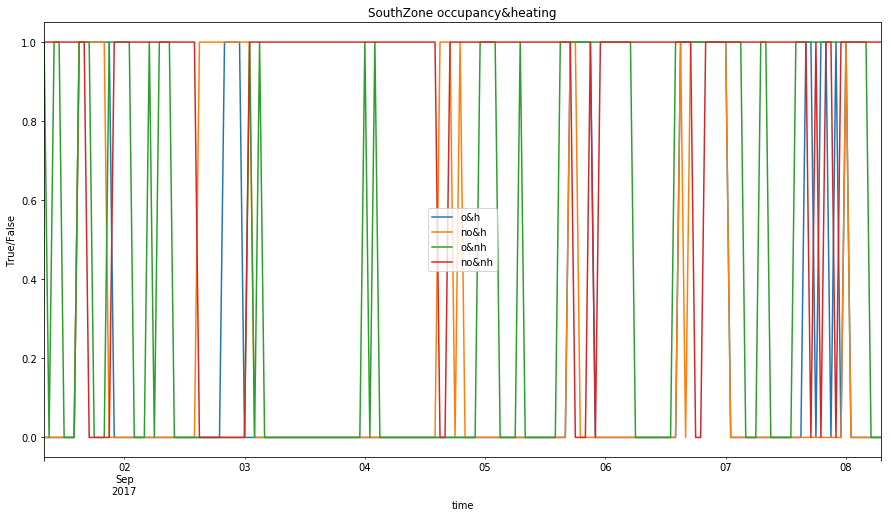

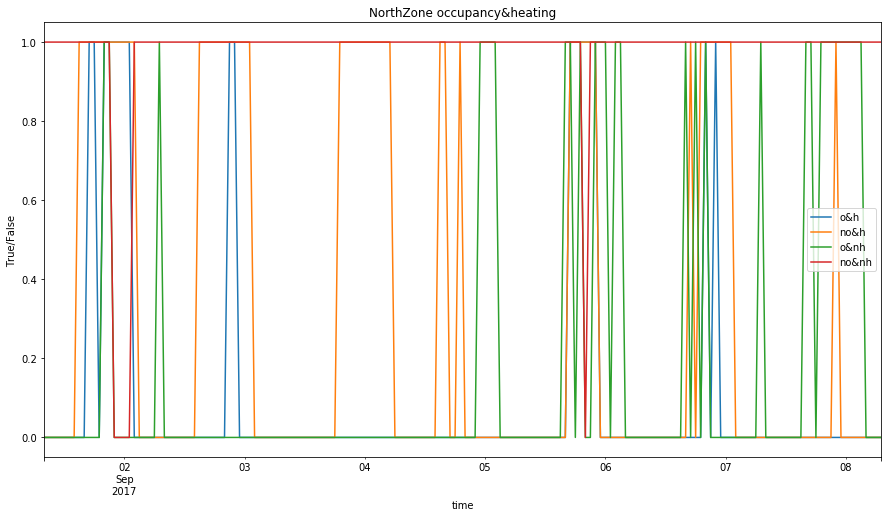

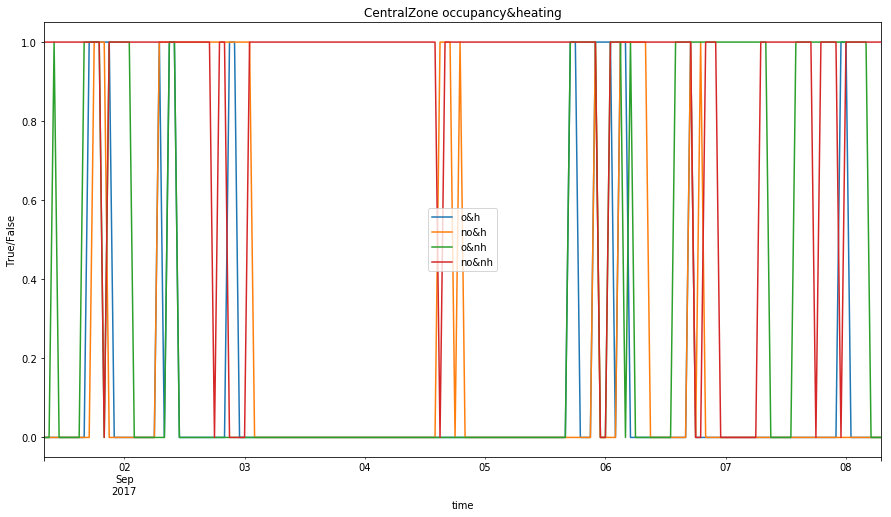

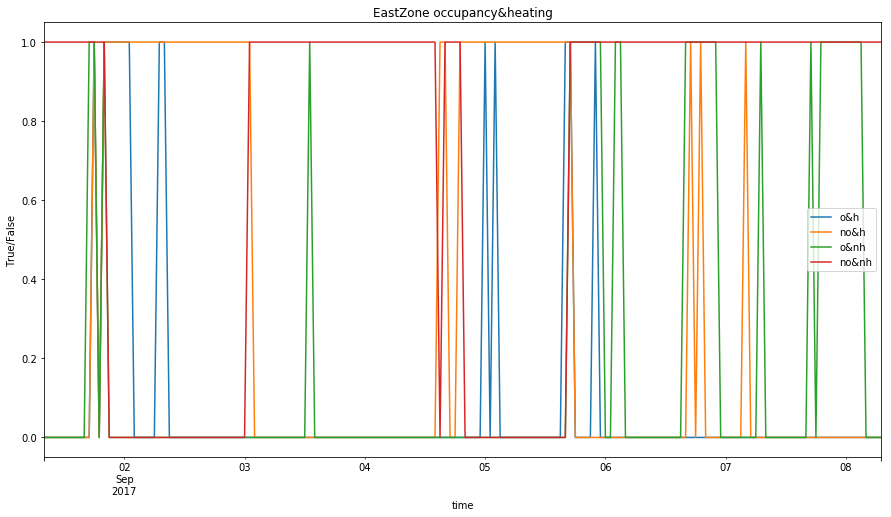

In [62]:
for zone, heating_occupancy in zone_ho.items():
    time_spent = heating_occupancy.sum(axis=0) * 0.5 / 60
    print("Times for: " + str(zone) + " in hours:")
    print(time_spent)
#     print("Ratio: "+str(time))
    figure = heating_occupancy.resample("1H").max().plot(legend=True, figsize=(15,8))
    figure.set_title(zone+ " occupancy&heating")
    figure.set_ylabel("True/False")

# Find histogram of occupancy

In [9]:
def get_occupancy(start='"2017-09-01 00:00:00 MST"', end='"2017-09-12 00:00:00 MST"', time_steps="15T"):
    """Returns a dictionary {Zone: occupancy_data} where the occupancy data is a pandas
    dataframe, where each column represents a sensor. It is indexed as timeseries data with time_steps as given.
    It has all the data in the range of times start to end as given.
    Note, the data is given in MST time as that is how it stores. We will convert it in the function to PST.
    Parameters:
        start: When should the data start. Has to be a string of a string '"Time"'.
        end: when should the data end. Has to be a string of a string '"Time"'.
        time_steps: in what intervals do we want to look at data. If a sensor regiester someone in those 15minutes,
                    then we will treat the whole 15 minute as being occupied. (Is this a valid assumption?)
    
    IMPROVEMENT TO GABE: change that the times have to be strings of strings. super confusing.
    IMPROVEMENT TO ME: maybe make it such that we don't have to store the data in a different cell. such that
            we only ever have to make a call to this function, and it will somehow store the already pulled function, 
            such that it doesn't have to pull it over and over again.
    """
    # define a Brick query to get the occupancy information
    q = """SELECT ?zone ?sensor_uuid WHERE {
       ?zone rdf:type brick:HVAC_Zone .
       ?zone bf:hasPart ?room .
       ?sensor bf:isLocatedIn ?room .
       ?sensor rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
       ?sensor bf:uuid ?sensor_uuid .
    };
    """
    result = hod.do_query(q)['Rows']
    occupancy_sensors = defaultdict(list)
    for sensor in result:
        occupancy_sensors[sensor['?zone']].append(sensor['?sensor_uuid'])
    zone_df = defaultdict()
    for zone, sensor_uuid in occupancy_sensors.items():
        occupancy_data = make_dataframe(archiver.data_uuids(sensor_uuid, start, end, timeout=300))
        occupancy_df = merge_dfs(occupancy_data, resample=time_steps, do_max=True)
        zone_df[zone] = 1*(occupancy_df > 0)
        idx = zone_df[zone].index
        idx = idx.tz_localize(pytz.utc).tz_convert(tz)
        zone_df[zone].index = idx
    return zone_df

In [10]:
def compute_envelope(start="08:00:00", end="18:00:00", time_steps="15T"):
    """Computes an envelope for a day. Will be filled with 1's from start to end, 
    and the time series will have a period of time_steps.
    Parameters:
            start: When the envelope should start. Provide pandas time string. should be less than end.
            end: When the envelope should end. Provdie pandas time string. should be greater than start.
            time_steps: the period of the indexing. Taken to be that if at time 08:15:00 we have a one, then 
                        in the period between 08:15:00 and 08:30:00 someone was by the occupancy sensor."""
    time = pd.DatetimeIndex(freq='15T', start='2017-01-01 00:00:00', end='2017-01-01 23:59:59')
    envelope = pd.Series(data=0, index=time)
    envelope.loc['2017-01-01 ' + start:'2017-01-01 ' + end] = 1
    return envelope

def hamming_distance(arr, compare_to):
    """Returns hamming distance of two numpy arrays. 
    >>> a = np.array([1,0,1])
    >>> b = np.array([0,1,0])
    >>> hamming_distance(a, b)
    3
    >>> c = np.array([1])
    >>> hamming_distance(a, c)
    1
    
    The last output is a result from appending an array of zeros to c to make a and c equal length."""
    return np.count_nonzero(arr != compare_to)

In [70]:
# store data in this cell, so we do not have to call get_occupancy at all times
# WE NEED TO CALL THIS CELL ONCE FROM HERE ON FORWARD!
zone_df_data = get_occupancy(start='"2017-09-01 00:00:00 MST"', end='"2017-09-10 00:00:00 MST"')

In [12]:
def get_zone_occupancy(cond=(lambda x: True)):
    """Returns the logical or of all sensors in a zone.
    Parameters:
        cond: A function by which to filter the data."""
    result = defaultdict()
    for zone, df in zone_df_data.items():
        temp = df[df.index.map(cond)]
        result[zone] = temp.apply(lambda x: max(x), axis = 1)
    return result

def get_building_occupany(cond=(lambda x: True)):
    """Returns the logical or of all sensors.
    Parameters:
        cond: A function by which to filter the data.
    Returns:
        pd.DataFrame"""
    
    result = None
    for key, value in zone_df_data.items():
        if result is None:
            result = value
        else:
            result = pd.concat([result, value], axis=1)
    result = result[result.index.map(cond)]
    result = result.apply(lambda x: max(x), axis=1)
    return pd.DataFrame(data=result.values, columns=["Occupied"], index=result.index)

In [77]:
def compute_histogram(data, cond, equivalence_range):
    """Creates a histogram of the data. The histograms will be computed for all equivalent dates for the
    given equivalence. For example, if we give the equivalence relation (lambda x, e: x.dayofweek == e) 
    and the list of equivalences we want to find [0,1,2,3,4,5,6], 
    then we will get a dictionary {e: histogram for equivalent days}. So, for Monday I would get
    {0: histogram for all mondays}.
    Frequency of histrogram will be the same as the data given.
    Parameters:
        data: The data for which to compute the histogram.
        cond: The condition by which to establish equivalence or the equialence relation. Has to have the input format
            cond(day, equivalence).
        equivalence_range: The equivalences we want to find."""
    histograms = defaultdict()
    for e in equivalence_range:
        temp = data[data.index.map(lambda d: cond(d, e))]
        histograms[e] = temp.groupby(by=lambda x: x.time()).sum()
    return histograms

In [84]:
weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def plot_weekday_histogram(plot_with_envelope=False):
    """Plots the weekday histograms.
    Parameters:
        plot_with_envelop: Plots the given envelope we have. Fromats it such that it fits to the index of
                        the output of compute_histogram. Also, will be scaled by the max of each histogram to 
                        make it more visible."""
    if plot_with_envelope:
        envelope = compute_envelope().groupby(lambda x: x.time()).sum()
    buildings = get_building_occupany()
    e=[0,1,2,3,4,5,6]
    his = compute_histogram(buildings, lambda d, e: d.weekday() == e, e)
    for i in e:
#         pd.DataFrame.hist(his[i])
        plt.figure()
        plt.plot(his[i])
        if plot_with_envelope:
            plt.plot(envelope*max(his[i]["Occupied"]))
        plt.title("Histogram for: "+ weekday_mapping[i] +".")
        plt.xlabel("Time of day.")
        plt.ylabel("Number of days the region was occupied.")
        plt.show()

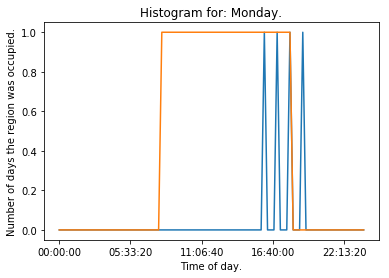

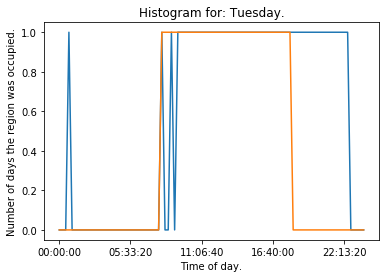

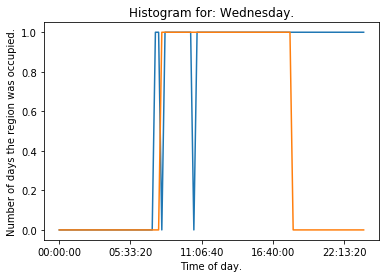

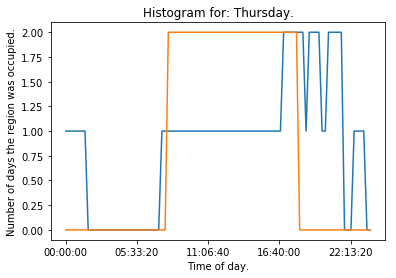

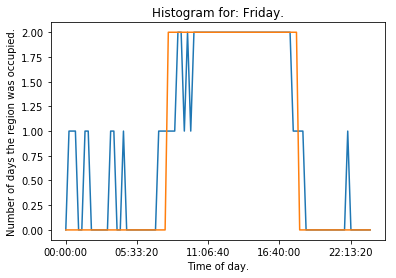

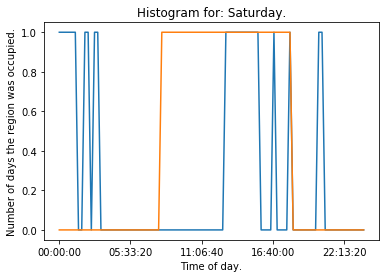

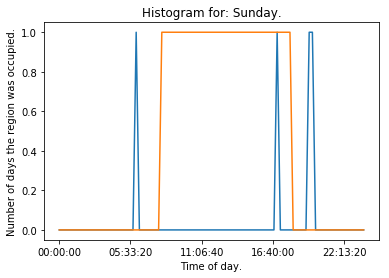

In [85]:
plot_weekday_histogram(True)

In [116]:
weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
def plot_distribution_overlay(data, env, kind="room"):
    global weekday_mapping
    """Implement it on a room basis for now. It will plot every day of the data given on one plot."""
    # Assume for one room for now
    dates = data.index.normalize().unique().date
    for date in dates:
        data_use = data[data.index.map(lambda x: x.date == date)]
        env_use = pd.DataFrame(data=env.values, columns=["Envelope"], index=data_use.index)
        def f(x, height, c):
            t = x["time"]
            curr_occ = x[c] == 1
            if curr_occ and f.occupied:
                f.temp[1] = t
            elif curr_occ and not f.occupied:
                f.temp = [t, 0, height]
                f.occupied = True
            elif not curr_occ and f.occupied:
                f.temp[1] = t
                f.lines.append(f.temp)
                f.occupied = False
        col = data_use.columns
        h = 0
        f.lines = []
        f.temp = None
        f.occupied = False
        for c in col:
            data_use[c].reset_index().apply(lambda x: f(x, h, c), axis=1)
            h += 1
        points = []
        fig, ax = plt.subplots()
        for l in f.lines:
            points.append([(l[0].time(), l[2]), (l[1].time(), l[2])])
        for p in points:
            (x, y) = zip(*p)
            ax.add_line(plt_line.Line2D(x, y))
        
        f.lines = []
        f.temp = None
        f.occupied = False
        env_use.reset_index().apply(lambda x: f(x, h+1, "Envelope"), axis=1)
        points = []
        for l in f.lines:
            points.append([(l[0].time(), l[2]), (l[1].time(), l[2])])
        for p in points:
            (x, y) = zip(*p)
            ax.add_line(plt_line.Line2D(x, y, color='red'))
        
        plt.title("Distribution for day: " + str(date)+ ", " + str(weekday_mapping[date.weekday()]))
        plt.xlabel("Time of day.")
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: round(x/(4*60*15), 1)))
        ax.set_xlim(0,4*60*15*24)
        plt.plot()
        plt.show
        
        
    

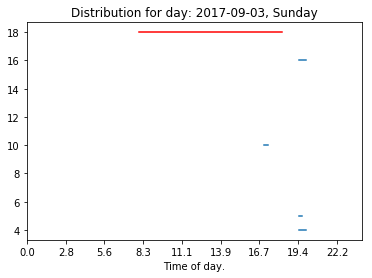

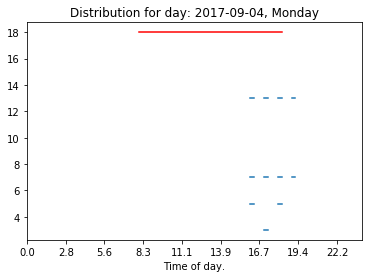

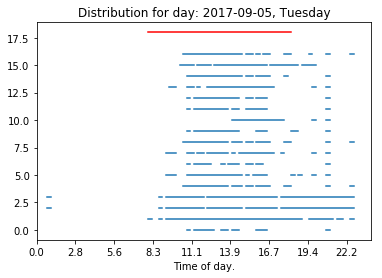

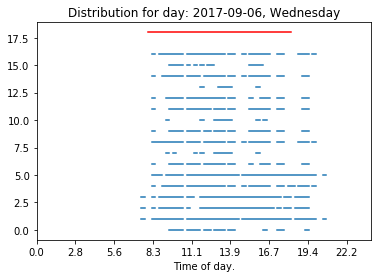

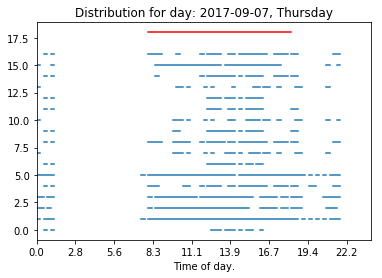

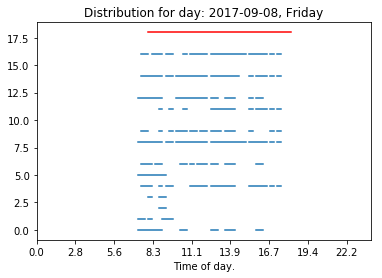

In [127]:
plot_distribution_overlay(zone_df_data["SouthZone"].loc["2017-09-03":"2017-09-08"], compute_envelope())

In [101]:
pd.to_datetime("2017-01-01 06:00:00").time()

datetime.time(6, 0)

In [118]:
# IMPROVE: on a room basis we can make this a helper function and jjust loop for each loop. 
# Maybe just return confusion matrix. Should be looked into.

def plot_confusion_matrix(data, env, time_step="15T", sensor=None):
    """Computes the confusion matrix for each day of a given week.
    Parameters:
            data: Should be a week of data.
            envelope: The prediction for each day.
            time_step: The time step to set all data to."""
    def assign_confusion(x):
        """If predicted and actualy YES then return 3.
            If predicted Yes and actual False return 2.
            If predicted False and actual True return 1
            If predicted False and actual False return 0"""
        if x["Envelope"] == 0:
            if x["Occupied"] == 0:
                return 0
            else:
                return 1
        if x["Occupied"] !=0:
            return 3
        return 2
    dates = data.index.normalize().unique().date
    confusion_matricies=defaultdict()
    for date in dates:
        data_use = data[data.index.map(lambda x: x.date == date)]
        env_use = pd.DataFrame(data=env.values, columns=["Envelope"], index=data_use.index)
        temp = pd.concat([data_use, env_use], axis=1)
        temp["Confusion"] = temp.apply(assign_confusion, axis=1)
        confusion_matricies[date] = temp["Confusion"].value_counts()
        
    for day, confusion in confusion_matricies.items():
        zero = confusion[0] if 0 in confusion.keys() else 0
        one = confusion[1] if 1 in confusion.keys() else 0
        two = confusion[2] if 2 in confusion.keys() else 0
        three = confusion[3] if 3 in confusion.keys() else 0
        
        data = [[three, one], [two, zero]]
        row = ["Actual True", "Actual False"]
        column = ["Predicted True", "Predicted False"]
        fig = plt.figure(figsize=(3,1))
        ax = fig.add_subplot(111)
#         ax.axis('square')
        ax.axis('off')
        the_table = ax.table(cellText=data, rowLabels=row, colLabels=column, loc='upper center')
        if sensor is not None:
            plt.title("Confusion Matrix for day: " + str(day) + "and sensor: "+ sensor)
        else:
            plt.title("Confusion Matrix for day: " + str(day))
        plt.show()

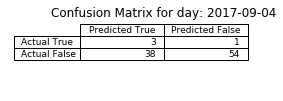

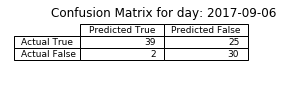

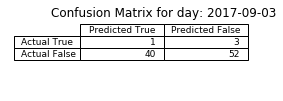

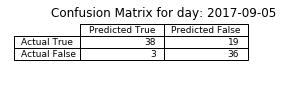

In [119]:
envelope = compute_envelope()
buildings= get_building_occupany()
d = buildings.loc["2017-09-03":"2017-09-06"]
plot_confusion_matrix(d, envelope)

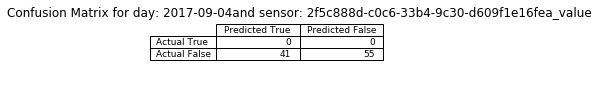

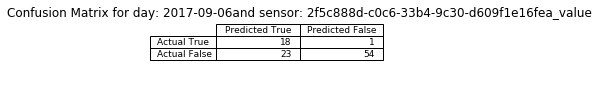

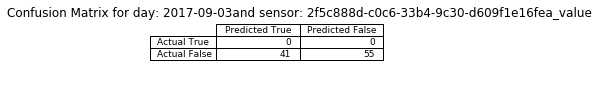

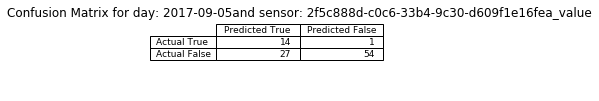

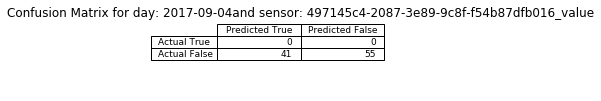

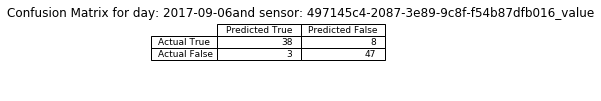

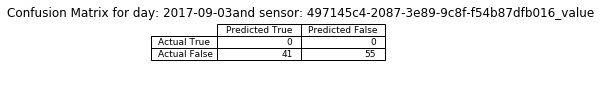

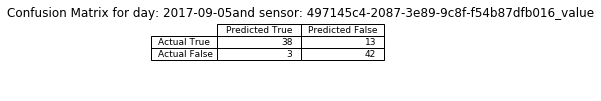

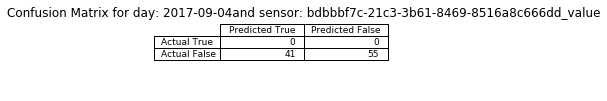

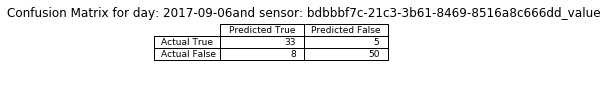

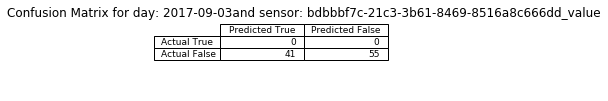

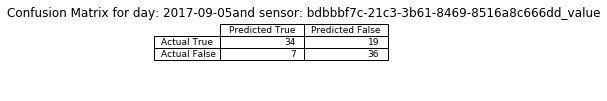

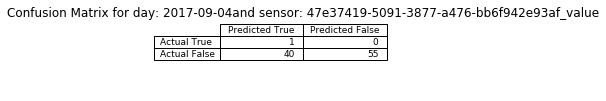

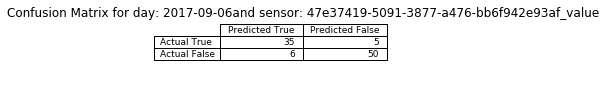

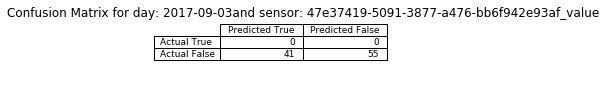

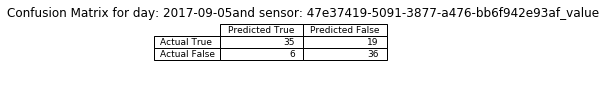

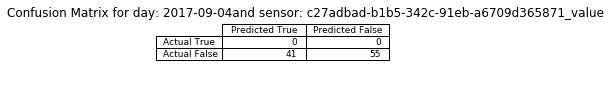

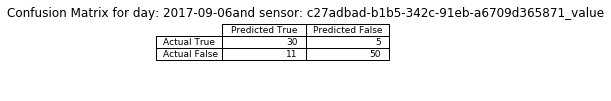

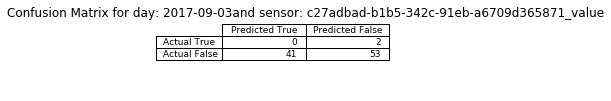

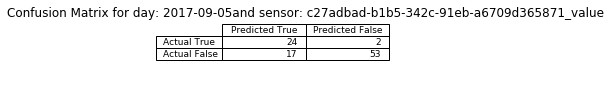

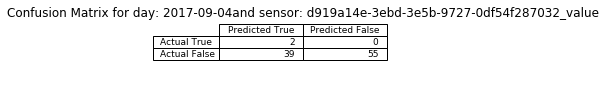

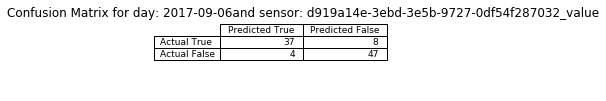

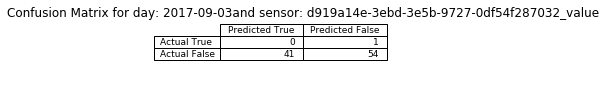

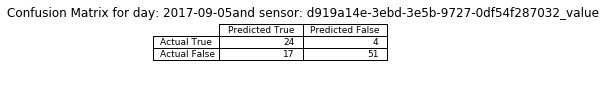

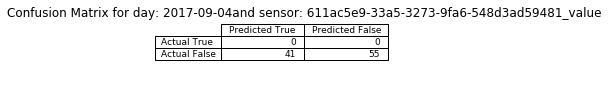

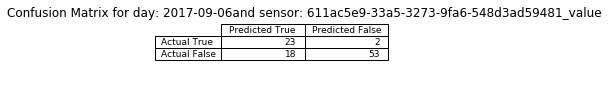

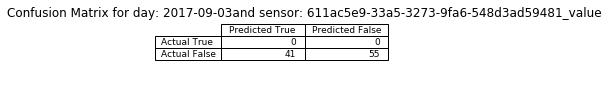

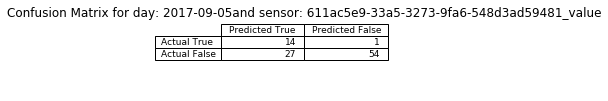

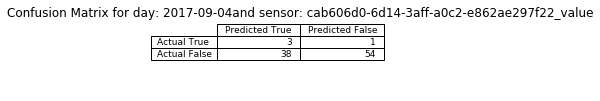

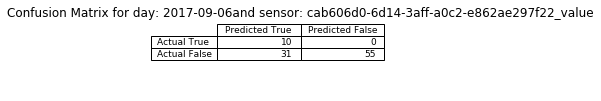

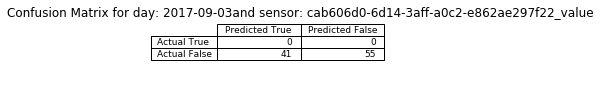

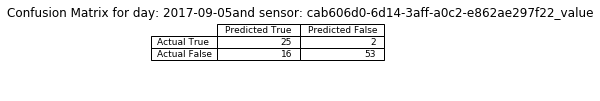

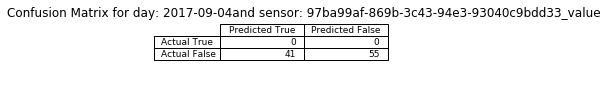

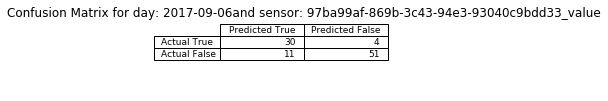

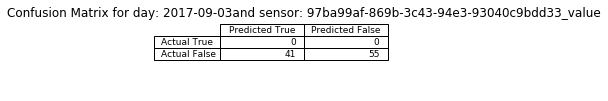

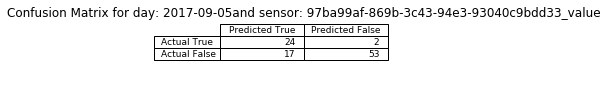

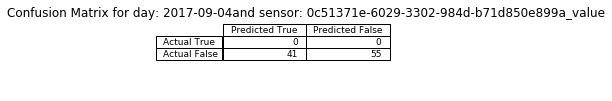

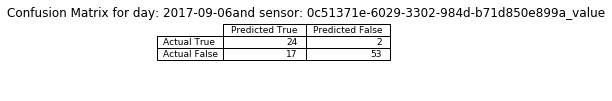

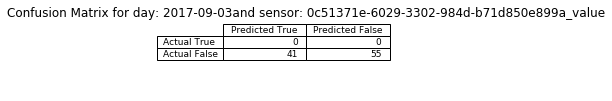

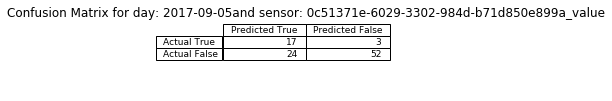

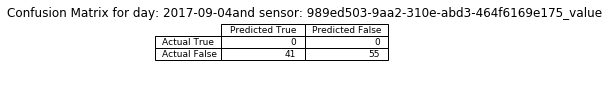

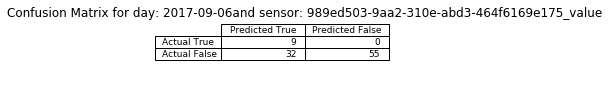

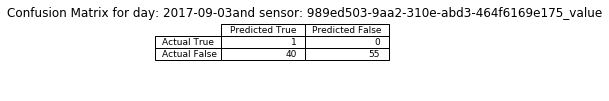

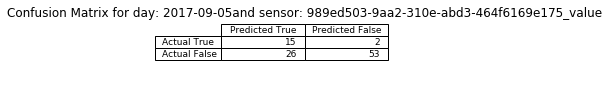

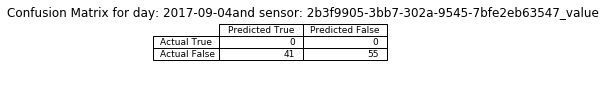

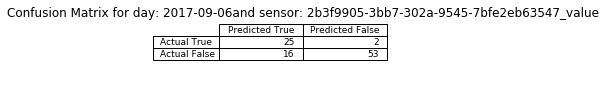

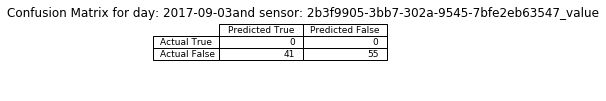

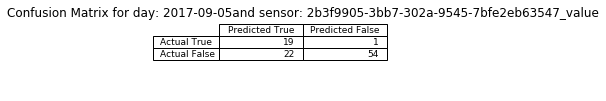

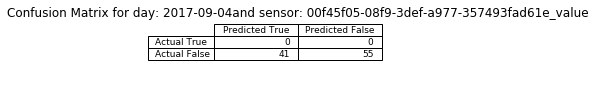

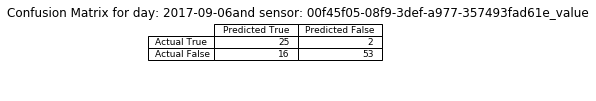

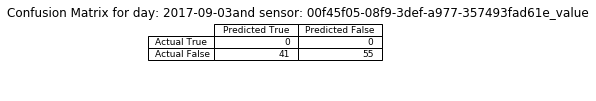

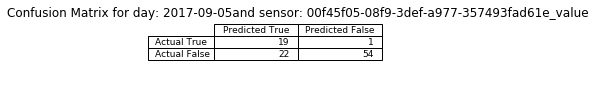

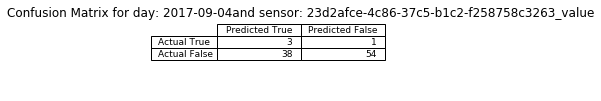

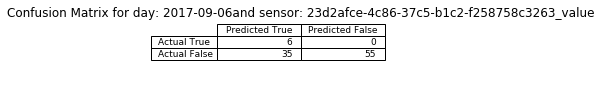

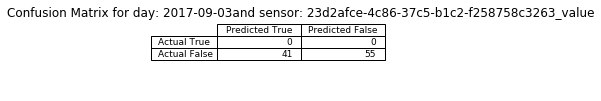

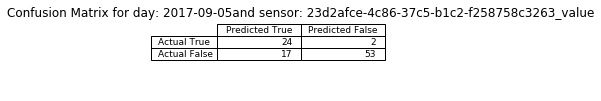

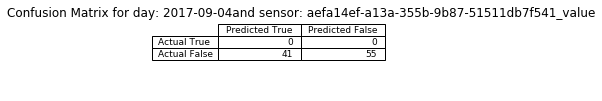

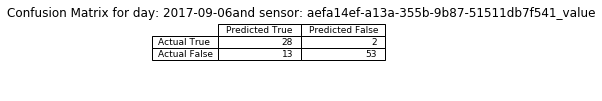

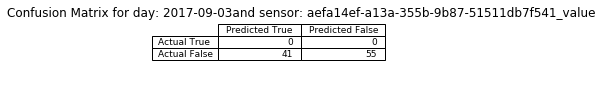

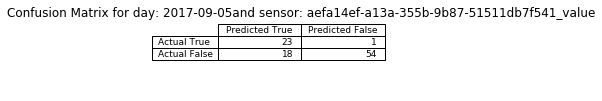

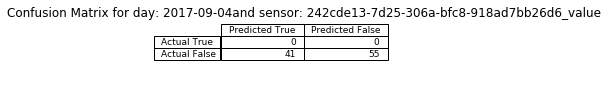

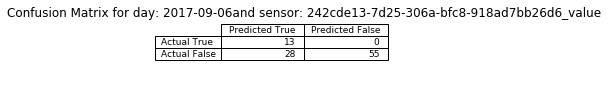

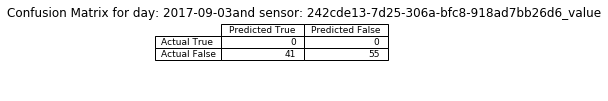

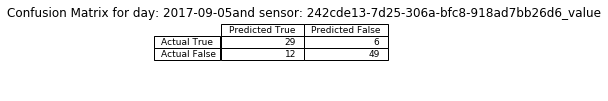

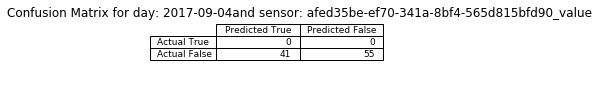

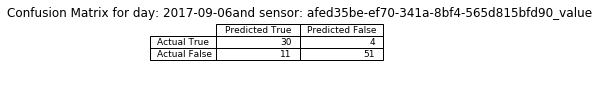

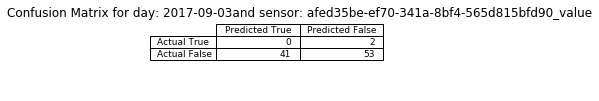

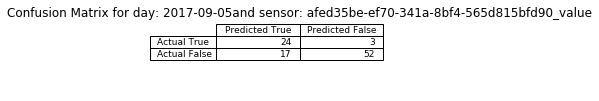

In [126]:
data = zone_df_data["SouthZone"]
for c in data.columns:
    d = data[c].loc["2017-09-03":"2017-09-06"]
    d = pd.DataFrame(data=d.values, columns=["Occupied"], index = d.index)
    plot_confusion_matrix(d, envelope, sensor=c)
    

In [122]:
# Find histogram for when people come and leave
def come_go(arr):
    arr = arr.loc[pd.to_datetime("03:00:00").time():pd.to_datetime("21:00:00").time()]
    come = arr.idxmax()
    go = arr[::-1].idxmax()
    return pd.DataFrame([[come, go]], columns=["come", "go"])